In [2]:
# using %matplotlib inline to immediatly draw plot after run
%matplotlib inline 

# imports
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import datetime
import os
import pickle
import sys
from dotenv import load_dotenv, find_dotenv
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import mutual_info_regression
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from catboost import CatBoostRegressor
from sklearn.model_selection import ShuffleSplit
from sklearn.base import clone
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error


"""prepare environment variable"""
load_dotenv(find_dotenv())
sys.path.append(os.getenv('PROJECT_DIR'))

from src.data.dataloader.data_loader import DataLoader
from src.data.datacleaner.data_cleaner import DataCleaner
from src.data.datagenerator.data_generator import DataGenerator
from src.data.dataselector.data_selector import DataSelector
from src.data.datatransformer.data_transformer import DataTransformer

## Data Modelling Baseline (No Feature Selection)

In [3]:
# ========================================================================================
# ============================== CROSS VALIDATION ========================================
# ========================================================================================

def preprocess_data(df: pd.DataFrame, dataset_type: str) -> pd.DataFrame:

    # ========================================================================================
    # Clean data
    # ========================================================================================
    cleaned_df = DataCleaner.drop_feature(dataset=df.copy(), columns=['Id'])
    cleaned_df = DataCleaner.change_feature_type(dataset=cleaned_df, mapper={'MSSubClass': str})
    cleaned_df = DataCleaner.impute_missing_numerical_feature(dataset=cleaned_df, dataset_type=dataset_type)
    cleaned_df = DataCleaner.impute_missing_categorical_feature(dataset=cleaned_df, dataset_type=dataset_type)

    # ========================================================================================
    # Data transformation (encoding & scaling)
    # ========================================================================================
    feature_transformed_df = DataTransformer.log_transform(cleaned_df)
    feature_transformed_df = DataTransformer.ordinal_encode(feature_transformed_df)
    feature_transformed_df = DataTransformer.one_hot_encode(feature_transformed_df)
    feature_transformed_df = DataTransformer.scale_data(dataset=feature_transformed_df, scaler_name='minmax', dataset_type=dataset_type)
    return feature_transformed_df

models = [
    LinearRegression(), Ridge(random_state=42), Lasso(random_state=42), 
    SVR(), DecisionTreeRegressor(random_state=42), RandomForestRegressor(random_state=42), 
    AdaBoostRegressor(random_state=42), GradientBoostingRegressor(random_state=42), 
    ExtraTreesRegressor(random_state=42), XGBRegressor(random_state=42), LGBMRegressor(random_state=42),
    CatBoostRegressor(random_state=42)
]

date = datetime.datetime.now().strftime('%Y%m%d')

model_names = [model.__class__.__name__ for model in models]
rmsles = []
rmses = []
maes = []
r2s = []

for model in models:
    # Load data
    # ========================================================================================
    train_df = DataLoader.load_data(os.getenv('TRAIN_PATH'))

    # prepare X and y
    # ========================================================================================
    X_train, y_train = train_df.drop(columns=['SalePrice']), train_df['SalePrice'].to_numpy()

    # perform shuffle split validation
    # ========================================================================================
    ss = ShuffleSplit(n_splits=5, random_state=42)
    rmsle = []
    
    # perform cross validation
    # ========================================================================================
    for train_index, val_index in ss.split(X_train):
        # Split based on generated index of folding
        # ========================================================================================
        X_train_fold, X_val_fold = X_train.iloc[train_index].reset_index(drop=True), X_train.iloc[train_index].reset_index(drop=True)
        y_train_fold, y_val_fold = y_train[train_index], y_train[train_index]

        # Preprocess training and validation data
        # ========================================================================================
        X_train_fold_preprocessed = preprocess_data(X_train_fold, dataset_type="train")
        X_val_fold_preprocessed = preprocess_data(X_val_fold, dataset_type="test")

        # Train
        # ========================================================================================
        cv_model = clone(model)
        cv_model.fit(X_train_fold_preprocessed, np.log1p(y_train_fold))

        # Predict & evaluate
        # ========================================================================================
        y_val_fold_pred = cv_model.predict(X_val_fold_preprocessed)
        y_val_fold_pred = np.expm1(y_val_fold_pred)
        y_val_fold_pred = np.where(y_val_fold_pred < 0, 0, y_val_fold_pred)
        rmsle.append(np.sqrt(mean_squared_error(np.log1p(y_val_fold), np.log1p(y_val_fold_pred))))

    # Record for final summary
    # ========================================================================================
    rmsles.append(np.mean(rmsle))
    print(f"{model.__class__.__name__} done")

pd.DataFrame({
    'model': model_names,
    'rmsle': rmsles,
}).sort_values(by=['rmsle'])

LinearRegression done
Ridge done
Lasso done
SVR done
DecisionTreeRegressor done
RandomForestRegressor done
AdaBoostRegressor done
GradientBoostingRegressor done
ExtraTreesRegressor done
XGBRegressor done
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001202 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3350
[LightGBM] [Info] Number of data points in the train set: 1314, number of used features: 160
[LightGBM] [Info] Start training from score 12.025324
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001686 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3338
[LightGBM] [Info] Number of

model         rmsle
4       DecisionTreeRegressor  7.493358e-17
8         ExtraTreesRegressor  1.312784e-14
9                XGBRegressor  9.797534e-03
11          CatBoostRegressor  3.734969e-02
10              LGBMRegressor  4.445946e-02
5       RandomForestRegressor  5.385572e-02
7   GradientBoostingRegressor  8.060225e-02
3                         SVR  9.181641e-02
0            LinearRegression  9.646663e-02
1                       Ridge  1.014550e-01
6           AdaBoostRegressor  1.509513e-01
2                       Lasso  3.983171e-01

In [4]:
# ========================================================================================
# =========================== TRAIN MODEL FOR KAGGLE =====================================
# ========================================================================================

models = [
    RandomForestRegressor(random_state=42), 
    XGBRegressor(random_state=42), 
    LGBMRegressor(random_state=42),
    CatBoostRegressor(random_state=42)
]

model_names = [model.__class__.__name__ for model in models]
rmses = []
maes = []
r2s = []

for model in models:
    # Load data
    # ========================================================================================
    train_df = DataLoader.load_data(os.getenv('TRAIN_PATH'))
    test_df = DataLoader.load_data(os.getenv('TEST_PATH'))

    # prepare X and y
    # ========================================================================================
    X_train, y_train = train_df.drop(columns=['SalePrice']), train_df['SalePrice'].to_numpy()
    X_test = test_df

    # Preprocess training and validation data
    # ========================================================================================
    X_train_preprocessed = preprocess_data(X_train, dataset_type="train")

    # Train
    # ========================================================================================
    model.fit(X_train_preprocessed, np.log1p(y_train))

    # Predict & evaluate
    # ========================================================================================
    X_test_preprocessed = preprocess_data(X_test, dataset_type="test")
    y_pred = model.predict(X_test_preprocessed)
    y_pred = np.expm1(y_pred)

    # Save model
    # ========================================================================================
    pickle.dump(model, open(os.path.join(os.getenv('MODELS_FOLDER'), f'{date}_{model.__class__.__name__.lower()}_baseline_model.pkl'), 'wb'))

    # Save to submit
    # ========================================================================================
    pd.DataFrame({
        'Id': test_df['Id'],
        'SalePrice': y_pred.ravel()
    }).to_csv(os.path.join(os.getenv('PROCESSED_FOLDER'), f'{date}_submission_{model.__class__.__name__.lower()}_baseline.csv'), index=False) # save

    print(f"{model.__class__.__name__} done")

RandomForestRegressor done
XGBRegressor done
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001941 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3443
[LightGBM] [Info] Number of data points in the train set: 1460, number of used features: 164
[LightGBM] [Info] Start training from score 12.024057
LGBMRegressor done
Learning rate set to 0.043466
0:	learn: 0.3873532	total: 3.9ms	remaining: 3.89s
1:	learn: 0.3757797	total: 7.97ms	remaining: 3.98s
2:	learn: 0.3649292	total: 11.3ms	remaining: 3.77s
3:	learn: 0.3542989	total: 14.6ms	remaining: 3.64s
4:	learn: 0.3450453	total: 18.3ms	remaining: 3.64s
5:	learn: 0.3367756	total: 21.5ms	remaining: 3.57s
6:	learn: 0.3286408	total: 24.8ms	remaining: 3.52s
7:	learn: 0.3203972	total: 28.4ms	remaining: 3.52s
8:	learn: 0.3126691	total: 32.3ms	remaining: 3.56s
9:	learn: 0.3048689	to

# Feature Selection
Selecting feature by using Mutual Information which calculate how each feature reduce the uncertainty of predicting the right SalePrice.

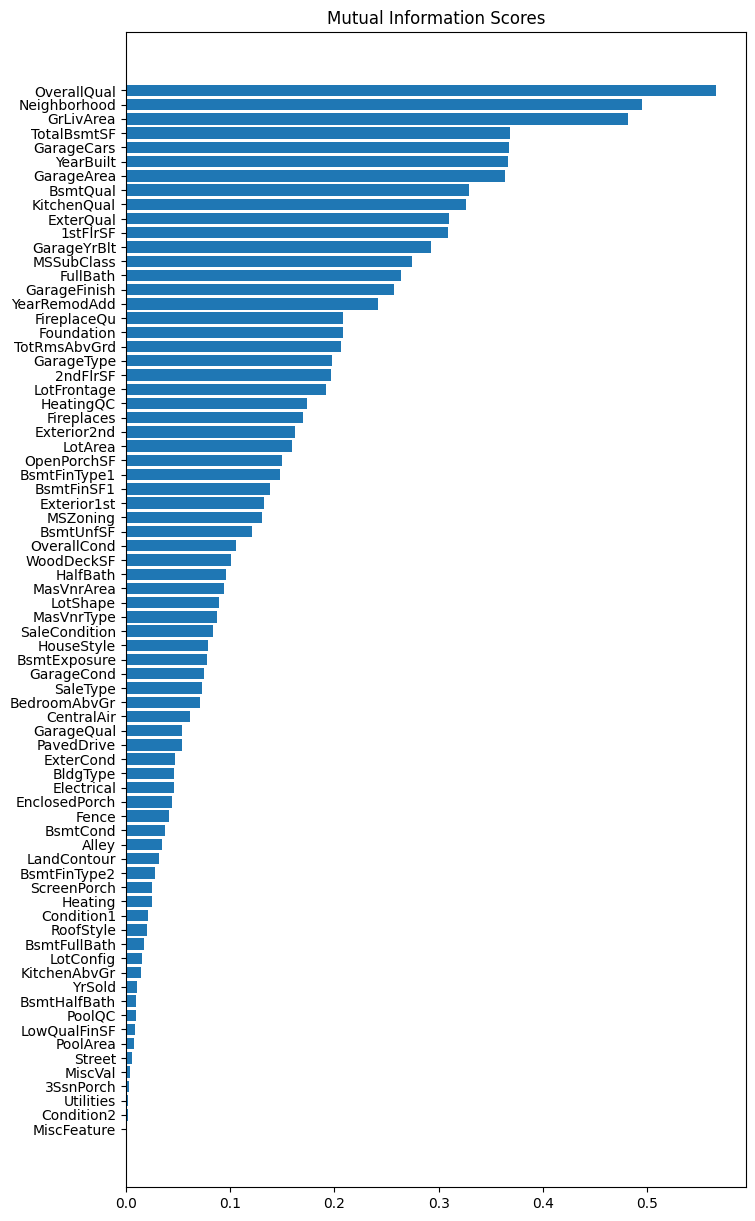

In [5]:
from sklearn.feature_selection import mutual_info_regression
def make_mi_scores(X, y, discrete_features=None):
    mi_scores = mutual_info_regression(X, y)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

# load data
# ========================================================================================
df = DataLoader.load_data(os.getenv('TRAIN_PATH'))

# clean data
# ========================================================================================
df = DataCleaner.drop_feature(dataset=df.copy(), columns=['Id'])
df = DataCleaner.change_feature_type(dataset=df, mapper={'MSSubClass': str})
df = DataCleaner.impute_missing_numerical_feature(dataset=df, dataset_type='train')
df = DataCleaner.impute_missing_categorical_feature(dataset=df, dataset_type='train')

# find discrete features
# ========================================================================================
categorical_features = df.select_dtypes(include=['object']).columns

# perform labelling on the categorical features
# ========================================================================================
for f in categorical_features:
    df.loc[:, f], _ = df[f].factorize()

# Calculate MI scores and use the features that has MI score above 0
# ========================================================================================
mi_scores = make_mi_scores(df, train_df['SalePrice'])
mi_scores = mi_scores[mi_scores > 0]
mi_scores = mi_scores.drop(index='SalePrice')


# plot the MI scores
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")


plt.figure(figsize=(8, 15))
plot_mi_scores(mi_scores)

In [6]:
mi_scores.index

Index(['OverallQual', 'Neighborhood', 'GrLivArea', 'TotalBsmtSF', 'GarageCars',
       'YearBuilt', 'GarageArea', 'BsmtQual', 'KitchenQual', 'ExterQual',
       '1stFlrSF', 'GarageYrBlt', 'MSSubClass', 'FullBath', 'GarageFinish',
       'YearRemodAdd', 'FireplaceQu', 'Foundation', 'TotRmsAbvGrd',
       'GarageType', '2ndFlrSF', 'LotFrontage', 'HeatingQC', 'Fireplaces',
       'Exterior2nd', 'LotArea', 'OpenPorchSF', 'BsmtFinType1', 'BsmtFinSF1',
       'Exterior1st', 'MSZoning', 'BsmtUnfSF', 'OverallCond', 'WoodDeckSF',
       'HalfBath', 'MasVnrArea', 'LotShape', 'MasVnrType', 'SaleCondition',
       'HouseStyle', 'BsmtExposure', 'GarageCond', 'SaleType', 'BedroomAbvGr',
       'CentralAir', 'GarageQual', 'PavedDrive', 'ExterCond', 'BldgType',
       'Electrical', 'EnclosedPorch', 'Fence', 'BsmtCond', 'Alley',
       'LandContour', 'BsmtFinType2', 'ScreenPorch', 'Heating', 'Condition1',
       'RoofStyle', 'BsmtFullBath', 'LotConfig', 'KitchenAbvGr', 'YrSold',
       'BsmtHalfBath', 

## Data Modelling with Feature Selection

In [7]:
# ========================================================================================
# ============================== CROSS VALIDATION ========================================
# ========================================================================================

def preprocess_data(df: pd.DataFrame, dataset_type: str) -> pd.DataFrame:

    # ========================================================================================
    # Clean data
    # ========================================================================================
    cleaned_df = DataCleaner.drop_feature(dataset=df.copy(), columns=['Id'])
    cleaned_df = DataCleaner.change_feature_type(dataset=cleaned_df, mapper={'MSSubClass': str})
    cleaned_df = DataCleaner.impute_missing_numerical_feature(dataset=cleaned_df, dataset_type=dataset_type)
    cleaned_df = DataCleaner.impute_missing_categorical_feature(dataset=cleaned_df, dataset_type=dataset_type)

    # ========================================================================================
    # Feature selection
    # ========================================================================================
    feature_selected_df = DataSelector.select_feature(cleaned_df, 
        ['OverallQual', 'Neighborhood', 'GrLivArea', 'GarageCars', 'TotalBsmtSF',
       'YearBuilt', 'GarageArea', 'BsmtQual', 'KitchenQual', 'ExterQual',
       '1stFlrSF', 'GarageYrBlt', 'MSSubClass', 'GarageFinish', 'FullBath',
       'YearRemodAdd', 'TotRmsAbvGrd', 'FireplaceQu', 'GarageType',
       'Foundation', '2ndFlrSF', 'LotFrontage', 'Fireplaces', 'Exterior2nd',
       'HeatingQC', 'LotArea', 'BsmtFinType1', 'OpenPorchSF', 'BsmtFinSF1',
       'Exterior1st', 'MSZoning', 'WoodDeckSF', 'BsmtUnfSF', 'OverallCond',
       'MasVnrType', 'MasVnrArea', 'HalfBath', 'SaleType', 'LotShape',
       'SaleCondition', 'HouseStyle', 'BedroomAbvGr', 'GarageCond',
       'CentralAir', 'GarageQual', 'BsmtExposure', 'PavedDrive', 'Fence',
       'BsmtCond', 'BsmtFinType2', 'Electrical', 'BldgType', 'Alley',
       'BsmtFullBath', 'Condition1', 'LandContour', 'BsmtHalfBath',
       'KitchenAbvGr', 'EnclosedPorch', 'ExterCond', 'Heating', 'ScreenPorch',
       'Utilities', 'RoofStyle', 'LotConfig', 'Functional', 'LandSlope',
       'Condition2', 'BsmtFinSF2', 'MiscFeature', 'MiscVal', 'PoolQC',
       '3SsnPorch', 'LowQualFinSF']
    )

    # ========================================================================================
    # Data transformation (encoding & scaling)
    # ========================================================================================
    feature_transformed_df = DataTransformer.log_transform(feature_selected_df)
    feature_transformed_df = DataTransformer.ordinal_encode(feature_transformed_df)
    feature_transformed_df = DataTransformer.one_hot_encode(feature_transformed_df)
    feature_transformed_df = DataTransformer.scale_data(dataset=feature_transformed_df, scaler_name='minmax', dataset_type=dataset_type)
    return feature_transformed_df

models = [
    LinearRegression(), Ridge(random_state=42), Lasso(random_state=42), 
    SVR(), DecisionTreeRegressor(random_state=42), RandomForestRegressor(random_state=42), 
    AdaBoostRegressor(random_state=42), GradientBoostingRegressor(random_state=42), 
    ExtraTreesRegressor(random_state=42), XGBRegressor(random_state=42), LGBMRegressor(random_state=42),
    CatBoostRegressor(random_state=42)
]

date = datetime.datetime.now().strftime('%Y%m%d')

model_names = [model.__class__.__name__ for model in models]
rmsles = []
rmses = []
maes = []
r2s = []

for model in models:
    # Load data
    # ========================================================================================
    train_df = DataLoader.load_data(os.getenv('TRAIN_PATH'))

    # prepare X and y
    # ========================================================================================
    X_train, y_train = train_df.drop(columns=['SalePrice']), train_df['SalePrice'].to_numpy()

    # perform shuffle split validation
    # ========================================================================================
    ss = ShuffleSplit(n_splits=5, random_state=42)
    rmsle = []
    
    # perform cross validation
    # ========================================================================================
    for train_index, val_index in ss.split(X_train):
        # Split based on generated index of folding
        # ========================================================================================
        X_train_fold, X_val_fold = X_train.iloc[train_index].reset_index(drop=True), X_train.iloc[train_index].reset_index(drop=True)
        y_train_fold, y_val_fold = y_train[train_index], y_train[train_index]

        # Preprocess training and validation data
        # ========================================================================================
        X_train_fold_preprocessed = preprocess_data(X_train_fold, dataset_type="train")
        X_val_fold_preprocessed = preprocess_data(X_val_fold, dataset_type="test")

        # Train
        # ========================================================================================
        cv_model = clone(model)
        cv_model.fit(X_train_fold_preprocessed, np.log1p(y_train_fold))

        # Predict & evaluate
        # ========================================================================================
        y_val_fold_pred = cv_model.predict(X_val_fold_preprocessed)
        y_val_fold_pred = np.expm1(y_val_fold_pred)
        y_val_fold_pred = np.where(y_val_fold_pred < 0, 0, y_val_fold_pred)
        rmsle.append(np.sqrt(mean_squared_error(np.log1p(y_val_fold), np.log1p(y_val_fold_pred))))

    # Record for final summary
    # ========================================================================================
    rmsles.append(np.mean(rmsle))
    print(f"{model.__class__.__name__} done")

pd.DataFrame({
    'model': model_names,
    'rmsle': rmsles,
}).sort_values(by=['rmsle'])

LinearRegression done
Ridge done
Lasso done
SVR done
DecisionTreeRegressor done
RandomForestRegressor done
AdaBoostRegressor done
GradientBoostingRegressor done
ExtraTreesRegressor done
XGBRegressor done
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001951 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3331
[LightGBM] [Info] Number of data points in the train set: 1314, number of used features: 157
[LightGBM] [Info] Start training from score 12.025324
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002421 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3319
[LightGBM] [Info] Number of data points in the train set: 1314, number of used features: 15

model     rmsle
4       DecisionTreeRegressor  0.000875
8         ExtraTreesRegressor  0.000875
9                XGBRegressor  0.011446
11          CatBoostRegressor  0.039066
10              LGBMRegressor  0.045196
5       RandomForestRegressor  0.053496
7   GradientBoostingRegressor  0.080760
3                         SVR  0.091971
0            LinearRegression  0.103410
1                       Ridge  0.106163
6           AdaBoostRegressor  0.151044
2                       Lasso  0.398317

We don't pick Decision Tree Regressor and Extra Tree Regressor because it is a clear indication of overfitting.

In [8]:
# ========================================================================================
# =========================== TRAIN MODEL FOR KAGGLE =====================================
# ========================================================================================

models = [
    RandomForestRegressor(random_state=42), 
    XGBRegressor(random_state=42), 
    LGBMRegressor(random_state=42),
    CatBoostRegressor(random_state=42)
]

model_names = [model.__class__.__name__ for model in models]

for model in models:
    # Load data
    # ========================================================================================
    train_df = DataLoader.load_data(os.getenv('TRAIN_PATH'))
    test_df = DataLoader.load_data(os.getenv('TEST_PATH'))

    # prepare X and y
    # ========================================================================================
    X_train, y_train = train_df.drop(columns=['SalePrice']), train_df['SalePrice'].to_numpy()
    X_test = test_df

    # Preprocess training and validation data
    # ========================================================================================
    X_train_preprocessed = preprocess_data(X_train, dataset_type="train")

    # Train
    # ========================================================================================
    model.fit(X_train_preprocessed, np.log1p(y_train))

    # Predict & evaluate
    # ========================================================================================
    X_test_preprocessed = preprocess_data(X_test, dataset_type="test")
    y_pred = model.predict(X_test_preprocessed)
    y_pred = np.expm1(y_pred)

    # Save model
    # ========================================================================================
    pickle.dump(model, open(os.path.join(os.getenv('MODELS_FOLDER'), f'{date}_{model.__class__.__name__.lower()}_feature_selection_model.pkl'), 'wb'))

    # Save to submit
    # ========================================================================================
    pd.DataFrame({
        'Id': test_df['Id'],
        'SalePrice': y_pred.ravel()
    }).to_csv(os.path.join(os.getenv('PROCESSED_FOLDER'), f'{date}_submission_{model.__class__.__name__.lower()}_feature_selection.csv'), index=False) # save

    print(f"{model.__class__.__name__} done")

RandomForestRegressor done
XGBRegressor done
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001579 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3424
[LightGBM] [Info] Number of data points in the train set: 1460, number of used features: 161
[LightGBM] [Info] Start training from score 12.024057
LGBMRegressor done
Learning rate set to 0.043466
0:	learn: 0.3883720	total: 3.81ms	remaining: 3.81s
1:	learn: 0.3776024	total: 8.51ms	remaining: 4.25s
2:	learn: 0.3675828	total: 13.2ms	remaining: 4.4s
3:	learn: 0.3574469	total: 17.7ms	remaining: 4.4s
4:	learn: 0.3481466	total: 22ms	remaining: 4.37s
5:	learn: 0.3387960	total: 26.3ms	remaining: 4.36s
6:	learn: 0.3303684	total: 30.5ms	remaining: 4.33s
7:	learn: 0.3221117	total: 35.1ms	remaining: 4.35s
8:	learn: 0.3138648	total: 39.3ms	remaining: 4.33s
9:	learn: 0.3063021	total

# Feature Engineering
This part will explore what features that can be generated so that will will produce a good model

In [9]:
# load data
# ========================================================================================
df = DataLoader.load_data(os.getenv('TRAIN_PATH'))

# clean data
# ========================================================================================
df = DataCleaner.drop_feature(dataset=df.copy(), columns=['Id'])
df = DataCleaner.change_feature_type(dataset=df, mapper={'MSSubClass': str})
df = DataCleaner.impute_missing_numerical_feature(dataset=df, dataset_type='train')
df = DataCleaner.impute_missing_categorical_feature(dataset=df, dataset_type='train')

# feature selection
# ========================================================================================

df = df[
    [
        'OverallQual', 'Neighborhood', 'GrLivArea', 'GarageCars', 'TotalBsmtSF',
       'YearBuilt', 'GarageArea', 'BsmtQual', 'KitchenQual', 'ExterQual',
       '1stFlrSF', 'GarageYrBlt', 'MSSubClass', 'GarageFinish', 'FullBath',
       'YearRemodAdd', 'TotRmsAbvGrd', 'FireplaceQu', 'GarageType',
       'Foundation', '2ndFlrSF', 'LotFrontage', 'Fireplaces', 'Exterior2nd',
       'HeatingQC', 'LotArea', 'BsmtFinType1', 'OpenPorchSF', 'BsmtFinSF1',
       'Exterior1st', 'MSZoning', 'WoodDeckSF', 'BsmtUnfSF', 'OverallCond',
       'MasVnrType', 'MasVnrArea', 'HalfBath', 'SaleType', 'LotShape',
       'SaleCondition', 'HouseStyle', 'BedroomAbvGr', 'GarageCond',
       'CentralAir', 'GarageQual', 'BsmtExposure', 'PavedDrive', 'Fence',
       'BsmtCond', 'BsmtFinType2', 'Electrical', 'BldgType', 'Alley',
       'BsmtFullBath', 'Condition1', 'LandContour', 'BsmtHalfBath',
       'KitchenAbvGr', 'EnclosedPorch', 'ExterCond', 'Heating', 'ScreenPorch',
       'Utilities', 'RoofStyle', 'LotConfig', 'Functional', 'LandSlope',
       'Condition2', 'BsmtFinSF2', 'MiscFeature', 'MiscVal', 'PoolQC',
       '3SsnPorch', 'LowQualFinSF', 'SalePrice' # add SalePrice
    ]
]

## Generating Feature

In [10]:
import datetime
# generating feature
df['QualCond'] = df['OverallQual'] + df['OverallCond']
df['HouseAge'] = datetime.datetime.now().year - df['YearRemodAdd']
df['GarageAge'] = datetime.datetime.now().year - df['GarageYrBlt']
df['HouseArea'] = df['LotArea'] + df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF'] + df['GrLivArea']
# + df['WoodDeckSF'] + df['OpenPorchSF'] + df['EnclosedPorch'] + df['3SsnPorch'] + df['ScreenPorch']
df['BsmtBath'] = df['BsmtFullBath'] + df['BsmtHalfBath']
df['HouseBath'] = df['FullBath'] + df['HalfBath']

## KMeans Clustering

In [11]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler


cluster_features = ['LotArea','TotalBsmtSF','1stFlrSF','2ndFlrSF','GrLivArea']

def cluster_labels(df, features, n_clusters=20):
    X = df.copy()
    X = X[features]

    # standardize data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    kmeans = KMeans(n_clusters=n_clusters, n_init=20, random_state=42)
    return kmeans.fit_predict(X_scaled)

def cluster_distance(df, features, n_clusters=20):
    X = df.copy()
    X_scaled = X.loc[:, features]
    X_scaled = (X_scaled - X_scaled.mean(axis=0)) / X_scaled.std(axis=0)
    kmeans = KMeans(n_clusters=20, n_init=50, random_state=0)
    X_cd = kmeans.fit_transform(X_scaled)
    # Label features and join to dataset
    X_cd = pd.DataFrame(
        X_cd, columns=[f"Centroid_{i}" for i in range(X_cd.shape[1])]
    )
    return X_cd

df['ClusterHomeArea'] = cluster_labels(df, cluster_features)
df = pd.concat([df, cluster_distance(df, cluster_features)], axis=1)


## PCA

In [12]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

def apply_pca(X, standardize=True):
    # standardize data
    if standardize:
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
    
    pca = PCA(random_state=42)
    X_pca = pca.fit_transform(X)

    pc_columns = [f"PC_{i}" for i in range(X_pca.shape[1])]
    X_pca = pd.DataFrame(X_pca, columns=pc_columns)
    
    # Create loadings
    loadings = pd.DataFrame(
        pca.components_.T,  # transpose the matrix of loadings
        columns=pc_columns,  # so the columns are the principal components
        index=X.columns,  # and the rows are the original features
    )
    return pca, X_pca, loadings

pca, X_pca, loadings = apply_pca(df[['LotArea','TotalBsmtSF','1stFlrSF','2ndFlrSF','GrLivArea']])
loadings

PC_0      PC_1      PC_2      PC_3      PC_4
LotArea      0.999767 -0.020292 -0.007330 -0.000987  0.000041
TotalBsmtSF  0.011509  0.403434  0.551217 -0.730174  0.010688
1stFlrSF     0.011640  0.378822  0.461695  0.549477 -0.584184
2ndFlrSF     0.002247  0.363961 -0.662925 -0.307771 -0.577352
GrLivArea    0.013910  0.748903 -0.208505  0.264947  0.570333

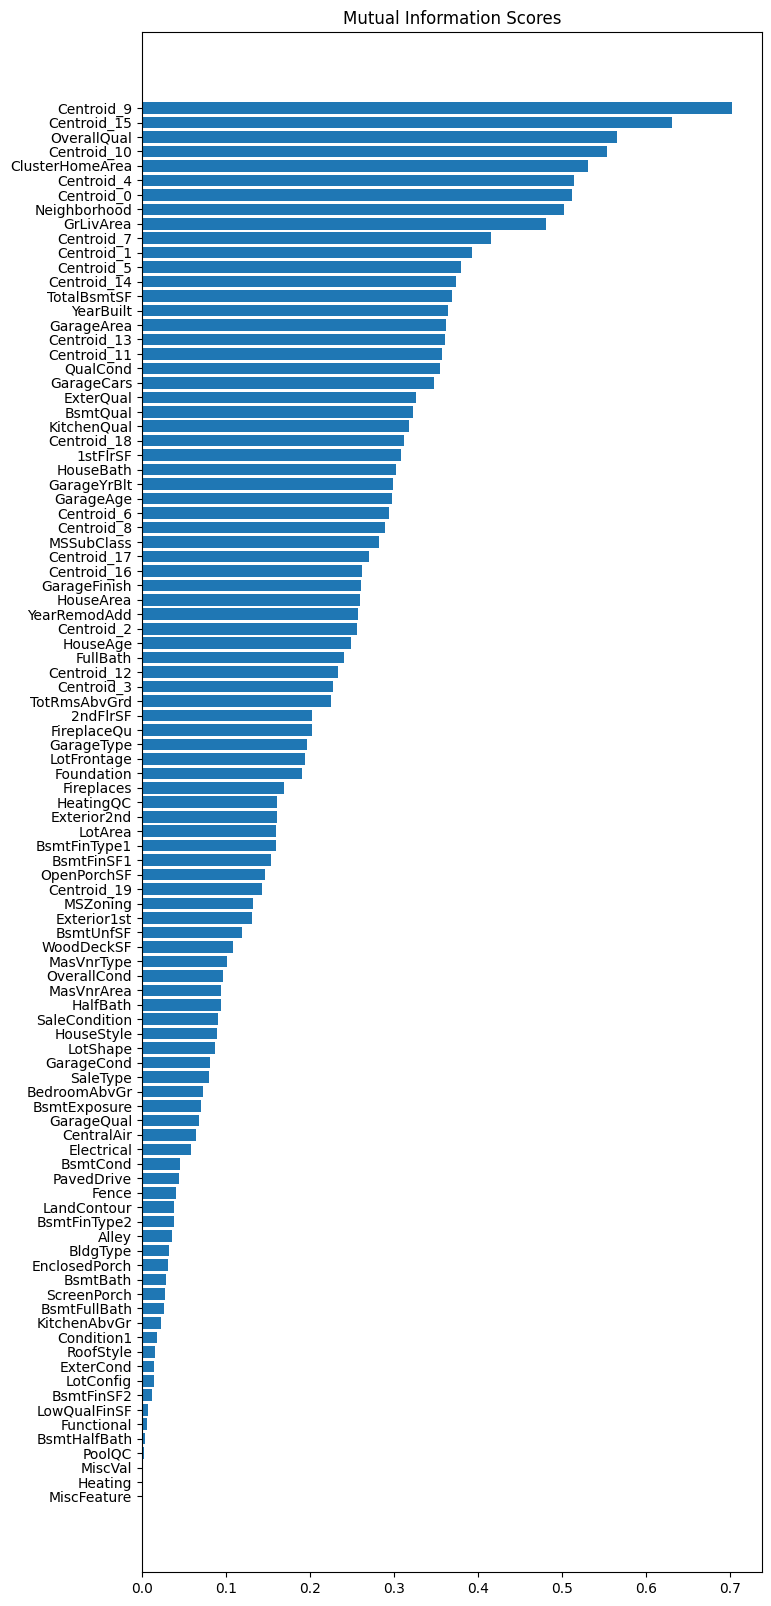

In [13]:
from sklearn.feature_selection import mutual_info_regression
def make_mi_scores(X, y, discrete_features=None):
    mi_scores = mutual_info_regression(X, y)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

# perform labelling on the categorical features
# ========================================================================================
categorical_features = df.select_dtypes(include=['object']).columns
for f in categorical_features:
    df.loc[:, f], _ = df[f].factorize()

# Calculate MI scores and use the features that has MI score above 0
# ========================================================================================
mi_scores = make_mi_scores(df, train_df['SalePrice'])
mi_scores = mi_scores[mi_scores > 0]
mi_scores = mi_scores.drop(index='SalePrice')


# plot the MI scores
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")


plt.figure(figsize=(8, 20))
plot_mi_scores(mi_scores)

## Perform Feature Selection

In [14]:
from sklearn.feature_selection import mutual_info_regression

def make_mi_scores(X, y, discrete_features=None):
    mi_scores = mutual_info_regression(X, y)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

In [15]:
# find discrete features
categorical_features = df.select_dtypes(include=['object']).columns

# perform labelling on the discrete features
temp_df = df.copy()[categorical_features]
for f in temp_df:
    temp_df.loc[:, f], _ = temp_df[f].factorize()

# Calculate MI scores and use the features that has MI score above 0.1
mi_scores = make_mi_scores(temp_df, train_df['SalePrice'])
mi_scores = mi_scores[mi_scores > 0.1]

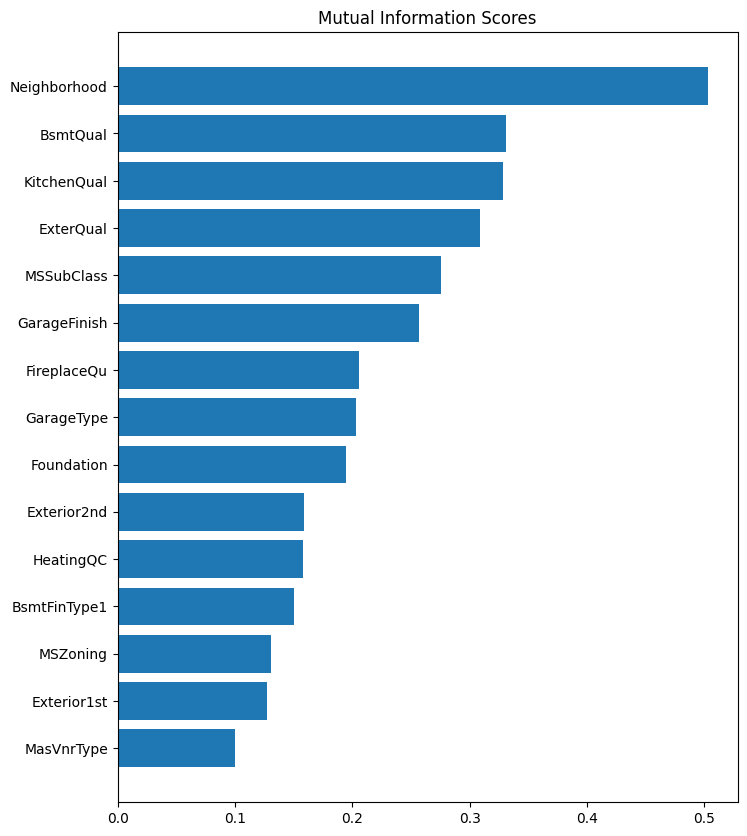

In [16]:
# plot the MI scores
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")


plt.figure(figsize=(8, 10))
plot_mi_scores(mi_scores)

In [17]:
mi_scores.index

Index(['Neighborhood', 'BsmtQual', 'KitchenQual', 'ExterQual', 'MSSubClass',
       'GarageFinish', 'FireplaceQu', 'GarageType', 'Foundation',
       'Exterior2nd', 'HeatingQC', 'BsmtFinType1', 'MSZoning', 'Exterior1st',
       'MasVnrType'],
      dtype='object')

# Data Modelling with Feature Engineering

In [18]:
# ========================================================================================
# =========================== TRAIN MODEL FOR KAGGLE =====================================
# ========================================================================================

def preprocess_data(df: pd.DataFrame, dataset_type: str) -> pd.DataFrame:

    # ========================================================================================
    # Clean data
    # ========================================================================================
    cleaned_df = DataCleaner.drop_feature(dataset=df.copy(), columns=['Id'])
    cleaned_df = DataCleaner.change_feature_type(dataset=cleaned_df, mapper={'MSSubClass': str})
    cleaned_df = DataCleaner.impute_missing_numerical_feature(dataset=cleaned_df, dataset_type=dataset_type)
    cleaned_df = DataCleaner.impute_missing_categorical_feature(dataset=cleaned_df, dataset_type=dataset_type)

    # ========================================================================================
    # Feature Engineering
    # ========================================================================================
    feature_engineered_df = DataGenerator.generate_feature_by_mean(cleaned_df, ['OverallQual', 'OverallCond'], 'QualCond')
    feature_engineered_df['HouseAge'] = datetime.datetime.now().year - feature_engineered_df['YearRemodAdd']
    feature_engineered_df['GarageAge'] = datetime.datetime.now().year - feature_engineered_df['GarageYrBlt']
    feature_engineered_df = DataGenerator.generate_feature_by_sum(feature_engineered_df, 
        ['TotalBsmtSF','1stFlrSF','2ndFlrSF','WoodDeckSF','OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch', 'GrLivArea'],
        'HouseArea'
    )
    feature_engineered_df = DataGenerator.generate_feature_by_sum(feature_engineered_df, ['FullBath', 'HalfBath'], 'HouseBath')
    feature_engineered_df = DataGenerator.generate_feature_by_mean(feature_engineered_df, ['BsmtFullBath', 'BsmtHalfBath'], 'BsmtBath')


    # ========================================================================================
    # Feature selection
    # ========================================================================================
    feature_selected_df = DataSelector.select_feature(feature_engineered_df, 
        [
            'QualCond', 'HouseAge','HouseArea', 'HouseBath', 'BsmtBath',
            'LotArea', 'LotFrontage', 'MasVnrArea', 'GarageArea', 'Fireplaces'
        ] 
        + cleaned_df.select_dtypes(include=['object']).columns.tolist()
    )


    # ========================================================================================
    # Data transformation (encoding & scaling)
    # ========================================================================================
    feature_transformed_df = DataTransformer.log_transform(feature_selected_df)
    feature_transformed_df = DataTransformer.ordinal_encode(feature_transformed_df)
    feature_transformed_df = DataTransformer.one_hot_encode(feature_transformed_df)
    feature_transformed_df = DataTransformer.scale_data(dataset=feature_transformed_df, scaler_name='standard', dataset_type=dataset_type)
    
    return feature_transformed_df

models = [
    LinearRegression(), Ridge(random_state=42), Lasso(random_state=42), 
    SVR(), DecisionTreeRegressor(random_state=42), RandomForestRegressor(random_state=42), 
    AdaBoostRegressor(random_state=42), GradientBoostingRegressor(random_state=42), 
    ExtraTreesRegressor(random_state=42), XGBRegressor(random_state=42), LGBMRegressor(random_state=42),
    CatBoostRegressor(random_state=42)
]

date = datetime.datetime.now().strftime('%Y%m%d')

model_names = [model.__class__.__name__ for model in models]
rmsles = []

for model in models:
    # Load data
    # ========================================================================================
    train_df = DataLoader.load_data(os.getenv('TRAIN_PATH'))

    # prepare X and y
    # ========================================================================================
    X_train, y_train = train_df.drop(columns=['SalePrice']), train_df['SalePrice'].to_numpy()

    # perform shuffle split validation
    # ========================================================================================
    ss = ShuffleSplit(n_splits=5, random_state=42)
    rmsle, rmse, mae, r2 = [], [], [], []

    for train_index, val_index in ss.split(X_train):
        # Split based on generated index of folding
        # ========================================================================================
        X_train_fold, X_val_fold = X_train.iloc[train_index].reset_index(drop=True), X_train.iloc[train_index].reset_index(drop=True)
        y_train_fold, y_val_fold = y_train[train_index], y_train[train_index]

        # Preprocess training and validation data
        # ========================================================================================
        X_train_fold_preprocessed = preprocess_data(X_train_fold, dataset_type="train")
        X_val_fold_preprocessed = preprocess_data(X_val_fold, dataset_type="test")

        # Train
        # ========================================================================================
        cv_model = clone(model)
        cv_model.fit(X_train_fold_preprocessed, np.log1p(y_train_fold))

        # Predict & evaluate
        # ========================================================================================
        y_val_fold_pred = cv_model.predict(X_val_fold_preprocessed)
        y_val_fold_pred = np.expm1(y_val_fold_pred)
        y_val_fold_pred = np.where(y_val_fold_pred < 0, 0, y_val_fold_pred)
        rmsle.append(np.sqrt(mean_squared_error(np.log1p(y_val_fold), np.log1p(y_val_fold_pred))))

    # Record for final summary
    # ========================================================================================
    rmsles.append(np.mean(rmsle))
    print(f"{model.__class__.__name__} done")

pd.DataFrame({
    'model': model_names,
    'rmsle': rmsles,
}).sort_values(by=['rmsle'])

LinearRegression done
Ridge done
Lasso done
SVR done
DecisionTreeRegressor done
RandomForestRegressor done
AdaBoostRegressor done
GradientBoostingRegressor done
ExtraTreesRegressor done
XGBRegressor done
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002137 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1542
[LightGBM] [Info] Number of data points in the train set: 1314, number of used features: 136
[LightGBM] [Info] Start training from score 12.025324
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001787 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1537
[LightGBM] [Info] Number of data points in the train set: 1314, number of used features: 13

model     rmsle
4       DecisionTreeRegressor  0.000875
8         ExtraTreesRegressor  0.000875
9                XGBRegressor  0.015783
11          CatBoostRegressor  0.043996
5       RandomForestRegressor  0.052975
10              LGBMRegressor  0.053201
3                         SVR  0.081452
7   GradientBoostingRegressor  0.086231
1                       Ridge  0.099485
0            LinearRegression  0.099517
6           AdaBoostRegressor  0.151083
2                       Lasso  0.398317

In [19]:
# ========================================================================================
# =========================== TRAIN MODEL FOR KAGGLE =====================================
# ========================================================================================
def preprocess_data(df: pd.DataFrame, dataset_type: str) -> pd.DataFrame:

    # ========================================================================================
    # Clean data
    # ========================================================================================
    cleaned_df = DataCleaner.drop_feature(dataset=df.copy(), columns=['Id'])
    cleaned_df = DataCleaner.change_feature_type(dataset=cleaned_df, mapper={'MSSubClass': str})
    cleaned_df = DataCleaner.impute_missing_numerical_feature(dataset=cleaned_df, dataset_type=dataset_type)
    cleaned_df = DataCleaner.impute_missing_categorical_feature(dataset=cleaned_df, dataset_type=dataset_type)

    # ========================================================================================
    # Feature Engineering
    # ========================================================================================
    feature_engineered_df = DataGenerator.generate_feature_by_mean(cleaned_df, ['OverallQual', 'OverallCond'], 'QualCond')
    feature_engineered_df['HouseAge'] = datetime.datetime.now().year - feature_engineered_df['YearRemodAdd']
    feature_engineered_df['GarageAge'] = datetime.datetime.now().year - feature_engineered_df['GarageYrBlt']
    feature_engineered_df = DataGenerator.generate_feature_by_sum(feature_engineered_df, 
        ['TotalBsmtSF','1stFlrSF','2ndFlrSF','WoodDeckSF','OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch', 'GrLivArea'],
        'HouseArea'
    )
    feature_engineered_df = DataGenerator.generate_feature_by_sum(feature_engineered_df, ['FullBath', 'HalfBath'], 'HouseBath')
    feature_engineered_df = DataGenerator.generate_feature_by_mean(feature_engineered_df, ['BsmtFullBath', 'BsmtHalfBath'], 'BsmtBath')


    # ========================================================================================
    # Feature selection
    # ========================================================================================
    feature_selected_df = DataSelector.select_feature(feature_engineered_df, 
        [
            'QualCond', 'HouseAge','HouseArea', 'HouseBath', 'BsmtBath',
            'LotArea', 'LotFrontage', 'MasVnrArea', 'GarageArea', 'Fireplaces'
        ] 
        + cleaned_df.select_dtypes(include=['object']).columns.tolist()
    )


    # ========================================================================================
    # Data transformation (encoding & scaling)
    # ========================================================================================
    feature_transformed_df = DataTransformer.log_transform(feature_selected_df)
    feature_transformed_df = DataTransformer.ordinal_encode(feature_transformed_df)
    feature_transformed_df = DataTransformer.one_hot_encode(feature_transformed_df)
    feature_transformed_df = DataTransformer.scale_data(dataset=feature_transformed_df, scaler_name='minmax', dataset_type=dataset_type)
    
    return feature_transformed_df

models = [
    XGBRegressor(random_state=42),
    GradientBoostingRegressor(random_state=42), 
    LGBMRegressor(random_state=42),
    CatBoostRegressor(random_state=42)
]

date = datetime.datetime.now().strftime('%Y%m%d')
model_names = [model.__class__.__name__ for model in models]
rmses = []
maes = []
r2s = []

for model in models:
    # Load data
    # ========================================================================================
    train_df = DataLoader.load_data(os.getenv('TRAIN_PATH'))
    test_df = DataLoader.load_data(os.getenv('TEST_PATH'))

    # Prepare X and y
    # ========================================================================================
    X_train, y_train = train_df.drop(columns=['SalePrice']), train_df['SalePrice'].to_numpy()
    X_test = test_df

    # Preprocess training and validation data
    # ========================================================================================
    X_train_preprocessed = preprocess_data(X_train, dataset_type="train")

    # Train
    # ========================================================================================
    model.fit(X_train_preprocessed, np.log1p(y_train))

    # Predict & evaluate
    # ========================================================================================
    X_test_preprocessed = preprocess_data(X_test, dataset_type="test")
    y_pred = model.predict(X_test_preprocessed)
    y_pred = np.expm1(y_pred)


    # Save model
    # ========================================================================================
    pickle.dump(model, open(os.path.join(os.getenv('MODELS_FOLDER'), f'{date}_{model.__class__.__name__.lower()}_fe_model.pkl'), 'wb'))

    # Save to submit
    # ========================================================================================
    pd.DataFrame({
        'Id': test_df['Id'],
        'SalePrice': y_pred.ravel()
    }).to_csv(os.path.join(os.getenv('PROCESSED_FOLDER'), f'{date}_submission_{model.__class__.__name__.lower()}_fe.csv'), index=False) # save

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001370 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1437
[LightGBM] [Info] Number of data points in the train set: 1460, number of used features: 140
[LightGBM] [Info] Start training from score 12.024057
Learning rate set to 0.043466
0:	learn: 0.3879269	total: 2.87ms	remaining: 2.86s
1:	learn: 0.3764380	total: 5.84ms	remaining: 2.91s
2:	learn: 0.3667552	total: 8.44ms	remaining: 2.81s
3:	learn: 0.3564096	total: 11.5ms	remaining: 2.85s
4:	learn: 0.3465268	total: 14ms	remaining: 2.79s
5:	learn: 0.3373349	total: 16.5ms	remaining: 2.73s
6:	learn: 0.3291715	total: 19.5ms	remaining: 2.77s
7:	learn: 0.3212718	total: 22.2ms	remaining: 2.76s
8:	learn: 0.3130865	total: 25.2ms	remaining: 2.77s
9:	learn: 0.3050975	total: 27.9ms	remaining: 2.76s
10:	learn: 0.2984491	total: 31.1ms	r

1. Using `OverallYear`, `FloorSF`, `OveralQualCond`,`TotalAbvGrd`, `TotalAbvGrd`, `HasAlley`, `HasMasVnr`, `HasFireplace`, `HasPool`, `HasFence`, `HasMiscFeature` improve CatBoostRegressor, LGBMRegressor, and GradientBoostingRegressor.

# Hypeparameter Tuning on The Best Model
The best model is CatBoostRegressor

In [20]:
# ========================================================================================
# =========================== TRAIN MODEL FOR KAGGLE =====================================
# ========================================================================================

def preprocess_data(df: pd.DataFrame, dataset_type: str) -> pd.DataFrame:

    # ========================================================================================
    # Clean data
    # ========================================================================================
    cleaned_df = DataCleaner.drop_feature(dataset=df.copy(), columns=['Id'])
    cleaned_df = DataCleaner.change_feature_type(dataset=cleaned_df, mapper={'MSSubClass': str})
    cleaned_df = DataCleaner.impute_missing_numerical_feature(dataset=cleaned_df, dataset_type=dataset_type)
    cleaned_df = DataCleaner.impute_missing_categorical_feature(dataset=cleaned_df, dataset_type=dataset_type)

    # ========================================================================================
    # Feature Engineering
    # ========================================================================================
    feature_engineered_df = DataGenerator.generate_feature_by_mean(cleaned_df, ['OverallQual', 'OverallCond'], 'QualCond')
    feature_engineered_df['HouseAge'] = datetime.datetime.now().year - feature_engineered_df['YearRemodAdd']
    feature_engineered_df['GarageAge'] = datetime.datetime.now().year - feature_engineered_df['GarageYrBlt']
    feature_engineered_df = DataGenerator.generate_feature_by_sum(feature_engineered_df, 
        ['TotalBsmtSF','1stFlrSF','2ndFlrSF','WoodDeckSF','OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch', 'GrLivArea'],
        'HouseArea'
    )
    feature_engineered_df = DataGenerator.generate_feature_by_sum(feature_engineered_df, ['FullBath', 'HalfBath'], 'HouseBath')
    feature_engineered_df = DataGenerator.generate_feature_by_mean(feature_engineered_df, ['BsmtFullBath', 'BsmtHalfBath'], 'BsmtBath')


    # ========================================================================================
    # Feature selection
    # ========================================================================================
    feature_selected_df = DataSelector.select_feature(feature_engineered_df, 
        [
            'QualCond', 'HouseAge','HouseArea', 'HouseBath', 'BsmtBath',
            'LotArea', 'LotFrontage', 'MasVnrArea', 'GarageArea', 'Fireplaces'
        ] 
        + cleaned_df.select_dtypes(include=['object']).columns.tolist()
    )


    # ========================================================================================
    # Data transformation (encoding & scaling)
    # ========================================================================================
    feature_transformed_df = DataTransformer.log_transform(feature_selected_df)
    feature_transformed_df = DataTransformer.ordinal_encode(feature_transformed_df)
    feature_transformed_df = DataTransformer.one_hot_encode(feature_transformed_df)
    feature_transformed_df = DataTransformer.scale_data(dataset=feature_transformed_df, scaler_name='standard', dataset_type=dataset_type)
    
    return feature_transformed_df


model = CatBoostRegressor(random_state=42)
date = datetime.datetime.now().strftime('%Y%m%d')

# Load data
# ========================================================================================
train_df = DataLoader.load_data(os.getenv('TRAIN_PATH'))
test_df = DataLoader.load_data(os.getenv('TEST_PATH'))

# Prepare X and y
# ========================================================================================
X_train, y_train = train_df.drop(columns=['SalePrice']), train_df['SalePrice'].to_numpy()
X_test = test_df

param_distributions = {
        'learning_rate': np.arange(0, 0.1, 0.01),
        'depth': [4, 5, 6, 7, 8, 9, 10],
        'l2_leaf_reg': [1, 3, 5, 7, 9]
    }



# Preprocess training and validation data
# ========================================================================================
X_train_preprocessed = preprocess_data(X_train, dataset_type="train")

# Train
# ========================================================================================
randomized_search_result = model.randomized_search(
    param_distributions,
    X=X_train_preprocessed,
    y=np.log1p(y_train),
    n_iter=20
)

0:	learn: 10.9500348	test: 10.9818489	best: 10.9818489 (0)	total: 18.5ms	remaining: 18.4s
1:	learn: 9.9703929	test: 10.0000584	best: 10.0000584 (1)	total: 20.4ms	remaining: 10.2s
2:	learn: 9.0822446	test: 9.1095456	best: 9.1095456 (2)	total: 22.7ms	remaining: 7.53s
3:	learn: 8.2715578	test: 8.2984957	best: 8.2984957 (3)	total: 24.7ms	remaining: 6.14s
4:	learn: 7.5317822	test: 7.5588707	best: 7.5588707 (4)	total: 26.6ms	remaining: 5.29s
5:	learn: 6.8619066	test: 6.8949988	best: 6.8949988 (5)	total: 28.8ms	remaining: 4.76s
6:	learn: 6.2502170	test: 6.2867623	best: 6.2867623 (6)	total: 30.8ms	remaining: 4.36s
7:	learn: 5.6942243	test: 5.7313189	best: 5.7313189 (7)	total: 32.9ms	remaining: 4.08s
8:	learn: 5.1843989	test: 5.2204830	best: 5.2204830 (8)	total: 33.8ms	remaining: 3.72s
9:	learn: 4.7220452	test: 4.7596318	best: 4.7596318 (9)	total: 35.9ms	remaining: 3.55s
10:	learn: 4.3017764	test: 4.3392747	best: 4.3392747 (10)	total: 37.9ms	remaining: 3.41s
11:	learn: 3.9176189	test: 3.9543011

In [21]:
randomized_search_result

{'params': {'depth': 4, 'l2_leaf_reg': 3, 'learning_rate': 0.05},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
               45,
               46,
    

In [22]:
# ========================================================================================
# =========================== TRAIN MODEL FOR KAGGLE =====================================
# ========================================================================================

def preprocess_data(df: pd.DataFrame, dataset_type: str) -> pd.DataFrame:

    # ========================================================================================
    # Clean data
    # ========================================================================================
    cleaned_df = DataCleaner.drop_feature(dataset=df.copy(), columns=['Id'])
    cleaned_df = DataCleaner.change_feature_type(dataset=cleaned_df, mapper={'MSSubClass': str})
    cleaned_df = DataCleaner.impute_missing_numerical_feature(dataset=cleaned_df, dataset_type=dataset_type)
    cleaned_df = DataCleaner.impute_missing_categorical_feature(dataset=cleaned_df, dataset_type=dataset_type)

    # ========================================================================================
    # Feature Engineering
    # ========================================================================================
    feature_engineered_df = DataGenerator.generate_feature_by_mean(cleaned_df, ['OverallQual', 'OverallCond'], 'QualCond')
    feature_engineered_df['HouseAge'] = datetime.datetime.now().year - feature_engineered_df['YearRemodAdd']
    feature_engineered_df['GarageAge'] = datetime.datetime.now().year - feature_engineered_df['GarageYrBlt']
    feature_engineered_df = DataGenerator.generate_feature_by_sum(feature_engineered_df, 
        ['TotalBsmtSF','1stFlrSF','2ndFlrSF','WoodDeckSF','OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch', 'GrLivArea'],
        'HouseArea'
    )
    feature_engineered_df = DataGenerator.generate_feature_by_sum(feature_engineered_df, ['FullBath', 'HalfBath'], 'HouseBath')
    feature_engineered_df = DataGenerator.generate_feature_by_mean(feature_engineered_df, ['BsmtFullBath', 'BsmtHalfBath'], 'BsmtBath')


    # ========================================================================================
    # Feature selection
    # ========================================================================================
    feature_selected_df = DataSelector.select_feature(feature_engineered_df, 
        [
            'QualCond', 'HouseAge','HouseArea', 'HouseBath', 'BsmtBath',
            'LotArea', 'LotFrontage', 'MasVnrArea', 'GarageArea', 'Fireplaces'
        ] 
        + cleaned_df.select_dtypes(include=['object']).columns.tolist()
    )


    # ========================================================================================
    # Data transformation (encoding & scaling)
    # ========================================================================================
    feature_transformed_df = DataTransformer.log_transform(feature_selected_df)
    feature_transformed_df = DataTransformer.ordinal_encode(feature_transformed_df)
    feature_transformed_df = DataTransformer.one_hot_encode(feature_transformed_df)
    feature_transformed_df = DataTransformer.scale_data(dataset=feature_transformed_df, scaler_name='standard', dataset_type=dataset_type)
    
    return feature_transformed_df

model = CatBoostRegressor(
    learning_rate = 0.06,
    random_state=42)


date = datetime.datetime.now().strftime('%Y%m%d')

# Load data
# ========================================================================================
train_df = DataLoader.load_data(os.getenv('TRAIN_PATH'))
test_df = DataLoader.load_data(os.getenv('TEST_PATH'))

# Prepare X and y
# ========================================================================================
X_train, y_train = train_df.drop(columns=['SalePrice']), train_df['SalePrice'].to_numpy()
X_test = test_df
# Preprocess training and validation data
# ========================================================================================
X_train_preprocessed = preprocess_data(X_train, dataset_type="train")

# Train Model
# ========================================================================================
model.fit(X_train_preprocessed, np.log1p(y_train))

# Predict & evaluate
# ========================================================================================
X_test_preprocessed = preprocess_data(X_test, dataset_type="test")
y_pred = model.predict(X_test_preprocessed)
y_pred = np.expm1(y_pred).astype(int)


# Save model
# ========================================================================================
pickle.dump(model, open(os.path.join(os.getenv('MODELS_FOLDER'), f'{date}_{model.__class__.__name__.lower()}_hp_model.pkl'), 'wb'))

# Save to submit
# ========================================================================================
pd.DataFrame({
    'Id': test_df['Id'],
    'SalePrice': y_pred.ravel()
}).to_csv(os.path.join(os.getenv('PROCESSED_FOLDER'), f'{date}_submission_{model.__class__.__name__.lower()}_hp.csv'), index=False) # save

0:	learn: 0.3836383	total: 5.58ms	remaining: 5.58s
1:	learn: 0.3680826	total: 10.7ms	remaining: 5.34s
2:	learn: 0.3544305	total: 17.8ms	remaining: 5.92s
3:	learn: 0.3403630	total: 23.2ms	remaining: 5.79s
4:	learn: 0.3277338	total: 38.4ms	remaining: 7.63s
5:	learn: 0.3162634	total: 43.4ms	remaining: 7.19s
6:	learn: 0.3058955	total: 48.5ms	remaining: 6.89s
7:	learn: 0.2955187	total: 53.2ms	remaining: 6.59s
8:	learn: 0.2861496	total: 57.4ms	remaining: 6.32s
9:	learn: 0.2766963	total: 61.7ms	remaining: 6.11s
10:	learn: 0.2685695	total: 66.6ms	remaining: 5.99s
11:	learn: 0.2604040	total: 71.4ms	remaining: 5.88s
12:	learn: 0.2522826	total: 76.1ms	remaining: 5.78s
13:	learn: 0.2456657	total: 81.1ms	remaining: 5.71s
14:	learn: 0.2392710	total: 96.5ms	remaining: 6.33s
15:	learn: 0.2325759	total: 101ms	remaining: 6.21s
16:	learn: 0.2263007	total: 105ms	remaining: 6.06s
17:	learn: 0.2196632	total: 109ms	remaining: 5.93s
18:	learn: 0.2140678	total: 113ms	remaining: 5.83s
19:	learn: 0.2085283	total